# CIFAR-10 experiment

As a more complex example, consider the [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) image classification dataset, previously used in the PyTorch workshop. One limitation with this data is that we only have gold classes for each image, but we have no notion of how *well* a particular image fits into a particular class, or how much *uncertainty* the gold class might come with.

We will work with the CIFAR-10H dataset, which recruits about 50 human annotators per CIFAR image and has them label the category that each image belongs to. In addition, the __reaction time__ for each response is recorded. We will use this to try to model image-level uncertainty.

Our goal is to find the strangest, most confusing images in the entire dataset!

Download CIFAR-10H here, and extract `cifar10h-raw.zip`:

[https://github.com/jcpeterson/cifar-10h](https://github.com/jcpeterson/cifar-10h)

In [64]:
import numpy as np
import pandas as pd
import torch
import pyro
import os
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.distributions import constraints
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
from pyro.infer.autoguide.initialization import *
import pyro.poutine as poutine
from pyro.optim import Adam

# Data

Read the raw annotator data CSV using Pandas (you may need to change the filepath below).

In [65]:
df = pd.read_csv('cifar-10h/data/cifar10h-raw.csv')

df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1342,1342
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4305,6244
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2811,9274
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1136,10610
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4410,15994


We will first apply the following preprocessing steps:

1. We filter out any attention check items, as well as a handful of mistaken entries with negative reaction times.

2. We convert the reaction times from milliseconds to seconds -- this is in order to avoid potential numerical overflow issues when sampling from Pyro distributions later on.

3. We generate integer IDs for each unique image and category in the dataset

In [66]:
df = df[df['is_attn_check'] == 0]
df = df[df['reaction_time'] > 0]

df['reaction_time'] = df['reaction_time'] / 1000
df['image_id'] = df['image_filename'].astype('category').cat.codes
df['category_id'] = df['chosen_category'].astype('category').cat.codes

df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed,image_id,category_id
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.342,1342,1791,8
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4.305,6244,275,7
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2.811,9274,8573,7
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1.136,10610,3127,1
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4.410,15994,3649,2


## Plotting code

We'll want to be able to plot the actual images. For this, we need to load the original CIFAR-10 test set using torchvision (this will automatically download). We'll define a function to plot a 4x4 grid of images, given a list of image IDs from the CIFAR-10H dataset.

In [67]:
import torchvision

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified


In [68]:
def plot_grid(img_ids, title=None):
  fig, axs = plt.subplots(4, 4, figsize=(15,15))
  for idx, img_id in enumerate(img_ids):
      i = idx // 4
      j = idx % 4
      axs[i][j].imshow(np.transpose(np.reshape(test_dataset[img_id][0], (3, 32,32)), (1,2,0)))

  if title:
    fig.suptitle(title, fontsize=20)
  plt.show()

# Initial experiment

As a naïve approach, we might try to get the most uncertain images by just looking at the images with highest mean reaction times across annotators. More uncertainty should cause people to take longer, right?

In [69]:
df_img = df.pivot_table(index=['cifar10_test_test_idx'], values=['reaction_time'], aggfunc=np.mean)

most_uncertain = list(df_img.nlargest(16, columns=['reaction_time']).index)
most_certain = list(df_img.nsmallest(16, columns=['reaction_time']).index)

most_uncertain

[1739,
 5058,
 7781,
 1566,
 5563,
 2918,
 1146,
 3065,
 184,
 7735,
 9762,
 6325,
 9564,
 1994,
 7563,
 7560]

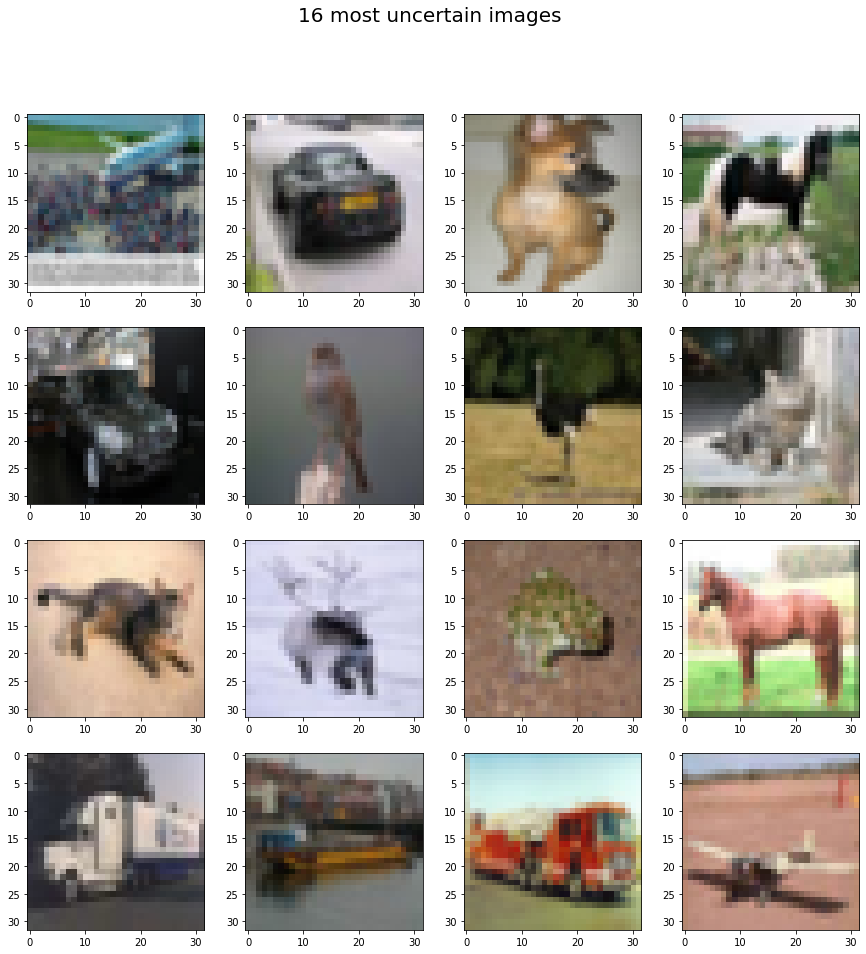

In [70]:
plot_grid(most_uncertain, title="16 most uncertain images")

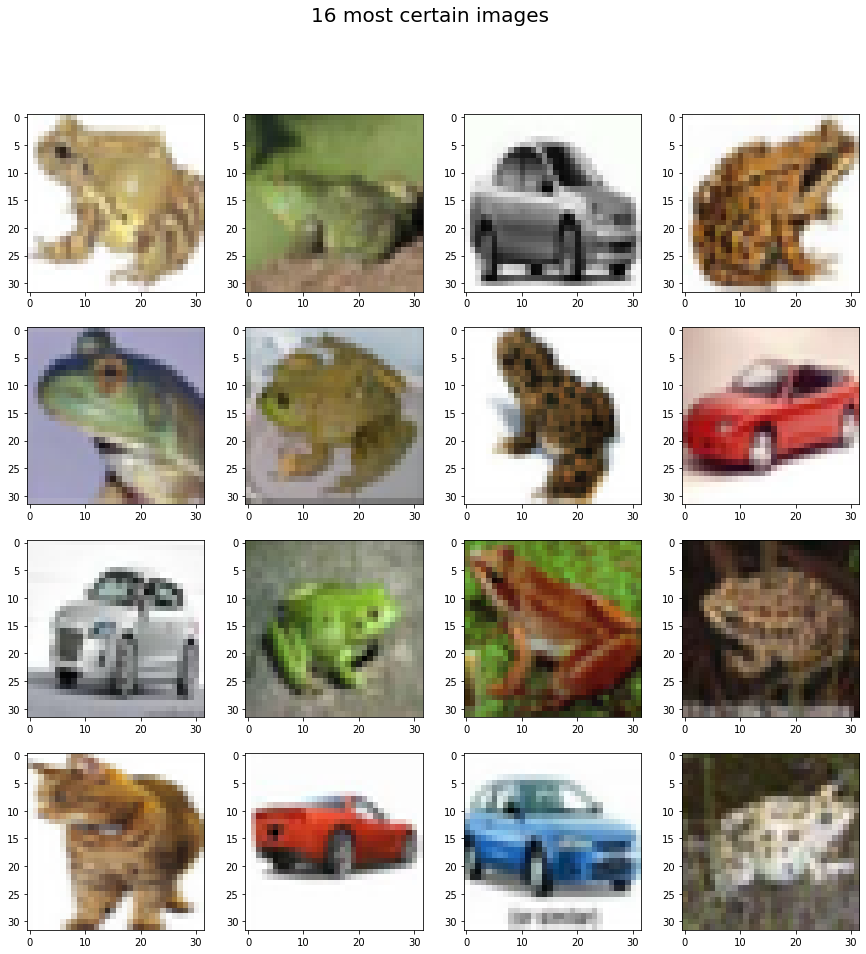

In [71]:
plot_grid(most_certain, title="16 most certain images")

### Analysis

The "uncertain" images here don't actually seem that strange. What gives?

One possibility is that some annotators had longer reaction times in general. Since the data was collected via MTurk, some of the annotators might have been multitasking. If this is the case, the mean reaction times will not give us the results we're looking for.

There might be other factors as well, but this possibility is the one that we will investigate further.

# Model

### We will first define some global variables that will be useful later on

In [72]:
CLASSES = df['category_id'].unique()
NUM_CLASSES = len(CLASSES)

In [73]:
LARGE_VARIANCE = 10.
MEAN_REACTION_TIME = df['reaction_time'].mean()

MEAN_REACTION_TIME

1.9358507919282444

## Model description

We will create a joint model for both the observed category annotations as well as the observed reaction times.

### Category annotations

The model will be a type of __mixture model__. This means that we will try to infer a soft clustering of images -- one cluster for each CIFAR category -- and model cluster membership for each unique image using a vector of weights. For example, if there are three categories, an image might have weights `[0.2, 0.7, 0.3]`, indicating that the most likely class is the middle one.

In order to model uncertainty, we will introduce a *prior* on the weights that, roughly speaking, controls how *sparse* or how *dense* the weights are. An image with sparse weights (e.g., `[0.9, 0.1, 0.0]`) will be more certain, whereas an image with dense weights (e.g., `[0.3, 0.4, 0.3]`) will be less certain. We will add a latent variable in our model called __dispersion__ in order to model this uncertainty.

Specifically, we will assume that the categorical weights are sampled from a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) prior distribution:

$
w_i \sim \text{Dirichlet}(\text{dispersion}_i \cdot \mathbf{1})
$

This distribution can be considered a distribution over probability vectors (i.e., a multivariate generalization of the Beta distribution), and with three categories it looks like the following:

![dirichlet_example](figures/dirichlet_example.png)

Distributions with high dispersion (dense, uncertain) will look more like the first two examples, whereas those with low dispersion (sparse, certain) will look more like the latter two examples.

We will also assume that the dispersion parameter itself is drawn from an [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution) prior.

### Reaction times

We will assume that reaction times are drawn from a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which is a common choice for modelling the time until some event. It has two parameters: a __location__ $\mu$ (sometimes called "concentration") and a __rate__ $\nu$ (sometimes called "scale"). Its PDF looks like this (where $k=\mu$ and $\theta = 1/\nu$):

<div>
<img src="figures/gamma_example.png" width="400"/>
</div>

The location parameter shifts the density around (i.e., to higher or lower response times), while the rate parameter affects the variance of the distribution.

Critically, we will introduce __mixed effects__ into our model. This means that the parameters of the reaction time distributions will be a combination of both _item-level_ and _participant-level_ parameters. In other words, a particular datapoint may have a long reaction time because the image demands a longer reaction time, or because that particular participant generally has longer reaction times. We will assume that the _image-level_ location parameter is related to the _dispersion_ of that image, i.e., more uncertain images generally increase reaction time.

Each location and rate parameter will be drawn from a [Log-Normal](https://en.wikipedia.org/wiki/Log-normal_distribution) prior with a large variance, which is a generally safe prior distribution to use for parameters that must be greater than zero. For the participant-level location parameter, we will assume that the mean of this prior is the overall mean reaction time across the entire dataset. Also, for simplicity we will only have a single image-level rate parameter (rather than a rate parameter for each image).

### Full distributional assumptions

$$
\begin{align*}
  \text{dispersion}_i  &\sim \text{Exponential}(1) \\
  w_i                  &\sim \text{Dirichlet}(\text{dispersion}_i \cdot \mathbf{1}) \\
  C_{i,p}              &\sim \text{Categorical}(w_i) \\
  \mu_i                &\sim \text{LogNormal}(\text{dispersion}_i, \sigma) \\
  \nu_0                  &\sim \text{LogNormal}(1, \sigma) \\
  \mu_p                &\sim \text{LogNormal}(\overline{T}, \sigma) \\
  \nu_p                  &\sim \text{LogNormal}(1, \sigma) \\
  T_{i, p}             &\sim \text{Gamma}(\mu_i + \mu_p, \nu_0 + \nu_p)        
\end{align*}
$$

## Model implementation

Implementing the model largely consists of translating the distributional assumptions into code.

The input arguments to the model should be a list of item indices corresponding to each response in the batch, a list of participant indices, a list of labels, and a list of reaction times. Each of these will have the same shape, i.e., `n_response`. We will also provide the number of unique images, participants, etc. for plate construction.

In [74]:
def model(image_idx, participant_idx, label, reaction_time,
          n_image, n_participant, n_response, n_categories):

  rate = pyro.sample("rate", dist.LogNormal(1., LARGE_VARIANCE))

  with pyro.plate('image_plate', n_image):
    dispersion = pyro.sample('dispersion', dist.Exponential(1.))
    locs = pyro.sample('locs', dist.LogNormal(dispersion, LARGE_VARIANCE))
    weights = pyro.sample('weights', dist.Dirichlet(dispersion.unsqueeze(-1) * torch.ones(n_categories)))

  with pyro.plate('participant_plate', n_participant):
    locs_participant = pyro.sample('locs_participant', dist.LogNormal(MEAN_REACTION_TIME, LARGE_VARIANCE))
    rates_participant = pyro.sample('rates_participant', dist.LogNormal(1., LARGE_VARIANCE))

  with pyro.plate(f'response_plate', n_response):
    chosen_label_obs = pyro.sample(f'chosen_label_obs', dist.Categorical(weights[image_idx]), obs=label)

    locs = locs[image_idx] + locs_participant[participant_idx]
    rates = rate + rates_participant[participant_idx]

    reaction_time_obs = pyro.sample(f'reaction_time_obs', dist.Gamma(locs, rates), obs=reaction_time)

    return chosen_label_obs, reaction_time_obs


### Convert data to Torch tensors of appropriate types

In [75]:
image_idx = torch.tensor(df['image_id'].values.astype(np.int64))
participant_idx = torch.tensor(df['annotator_id'].values.astype(np.int64))
label = torch.tensor(df['category_id'].values.astype(np.int64))
reaction_time = torch.tensor(df['reaction_time'].values.astype(np.float64))
n_image = len(np.unique(image_idx))
n_participant = len(np.unique(participant_idx))
n_response = len(label)
n_categories = 10

args = (image_idx, participant_idx, label, reaction_time, n_image, n_participant, n_response, n_categories)

In [76]:
model(*args)

(tensor([8, 7, 7,  ..., 1, 7, 0]),
 tensor([1.3420, 4.3050, 2.8110,  ..., 1.0940, 0.9610, 1.0630],
        dtype=torch.float64))

### Render model

Again, this requires [graphviz](https://graphviz.org/download/). We can see the distributional assumptions written manually above, as well as the causal structure of the program.

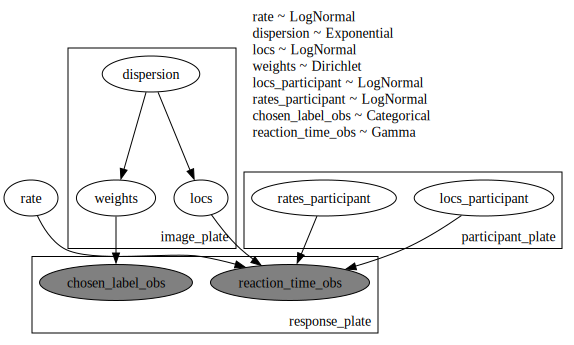

In [77]:
pyro.render_model(model, model_args=args, render_distributions=True, render_params=True)

# SVI

We can use the same training loop as in the CoinModel example.

In [78]:
def fit(model, guide, args, lr=0.005, n_steps=1000, verbosity=100):
    pyro.clear_param_store()
    adam_params = {"lr": lr}
    adam = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for step in range(n_steps):
        loss = svi.step(*args)
        if step % verbosity == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

def param(name):
    return pyro.get_param_store()[name].data.numpy()

# Experiment

Let's fit the model to the data now. Instead of creating a guide manually (which we can do if we want), we will make use of Pyro's AutoDelta class. This will automatically create an MAP estimator with a trainable parameter for each latent variable in the model.

In [79]:
fit(model, AutoDelta(model), args)

[iter 0]  loss: 2575294989.8464
[iter 100]  loss: 1487010083.6884
[iter 200]  loss: 1008625378.6231
[iter 300]  loss: 721135039.0609
[iter 400]  loss: 527150884.8027
[iter 500]  loss: 387568943.7130
[iter 600]  loss: 281098974.0664
[iter 700]  loss: 198737425.2543
[iter 800]  loss: 140040731.6437
[iter 900]  loss: 102525893.4880


# Analyzing results

We can see that the loss decreases, as expected. Let's repeat the analysis above in order to see what we've found. First, we need to retrieve the learned dispersion parameter from the AutoDelta guide, and merge it with the data (by image ID).

In [80]:
dispersion = param('AutoDelta.dispersion')
df_disp = pd.DataFrame(zip(range(len(dispersion)), dispersion), columns=['image_id', 'dispersion'])
df = df.merge(df_disp)

df

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed,image_id,category_id,dispersion
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.342,1342,1791,8,0.229705
1,97,9,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,3.131,69671,1791,8,0.229705
2,122,29,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.694,93018,1791,8,0.229705
3,176,207,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.659,873425,1791,8,0.229705
4,227,55,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.414,193612,1791,8,0.229705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514183,2376,128,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,1.689,294607,5694,8,0.279937
514184,2417,87,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,1.384,1005904,5694,8,0.279937
514185,2447,203,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,2.063,464993,5694,8,0.279937
514186,2482,65,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,1.500,129502,5694,8,0.279937


In [81]:
# Note that the aggfunc doesn't matter here, because all entries with the same image ID will have the same dispersion value anyways.
df_img = df.pivot_table(index=['cifar10_test_test_idx'], values=['dispersion'], aggfunc=np.mean)

most_uncertain = list(df_img.nlargest(16, columns=['dispersion']).index)
most_certain = list(df_img.nsmallest(16, columns=['dispersion']).index)

most_uncertain

[6750,
 5840,
 6024,
 86,
 2232,
 8153,
 1924,
 5398,
 3463,
 3357,
 5369,
 5158,
 9924,
 5227,
 6197,
 3139]

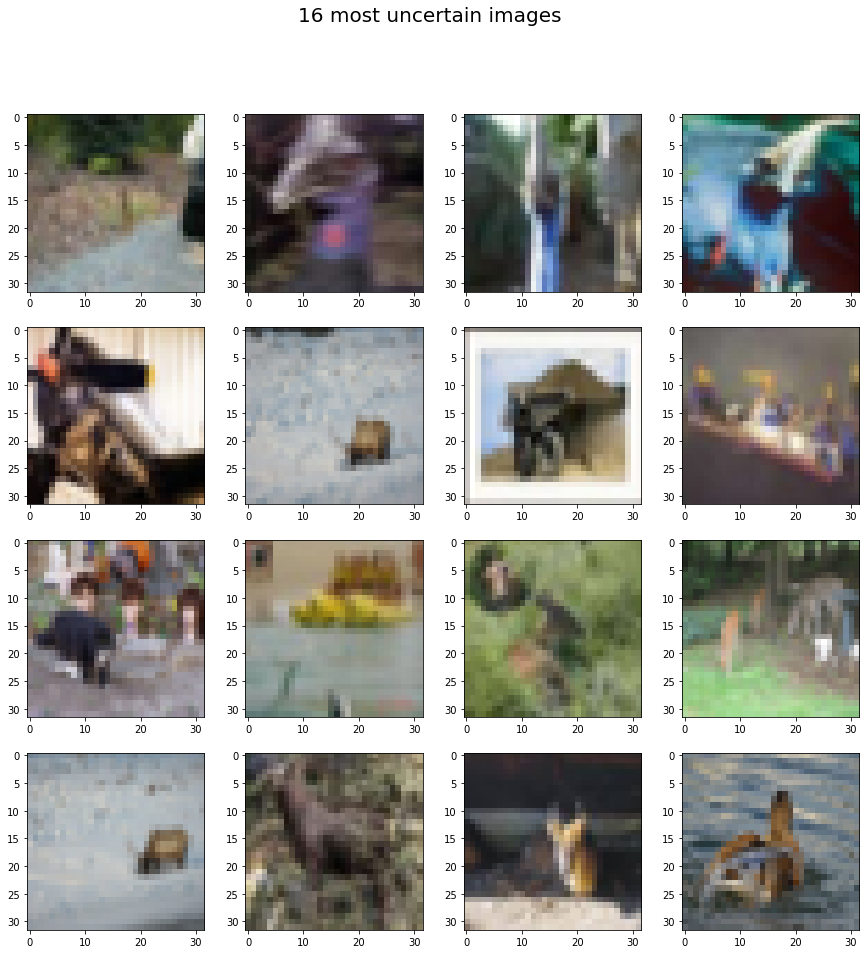

In [82]:
plot_grid(most_uncertain, title="16 most uncertain images")

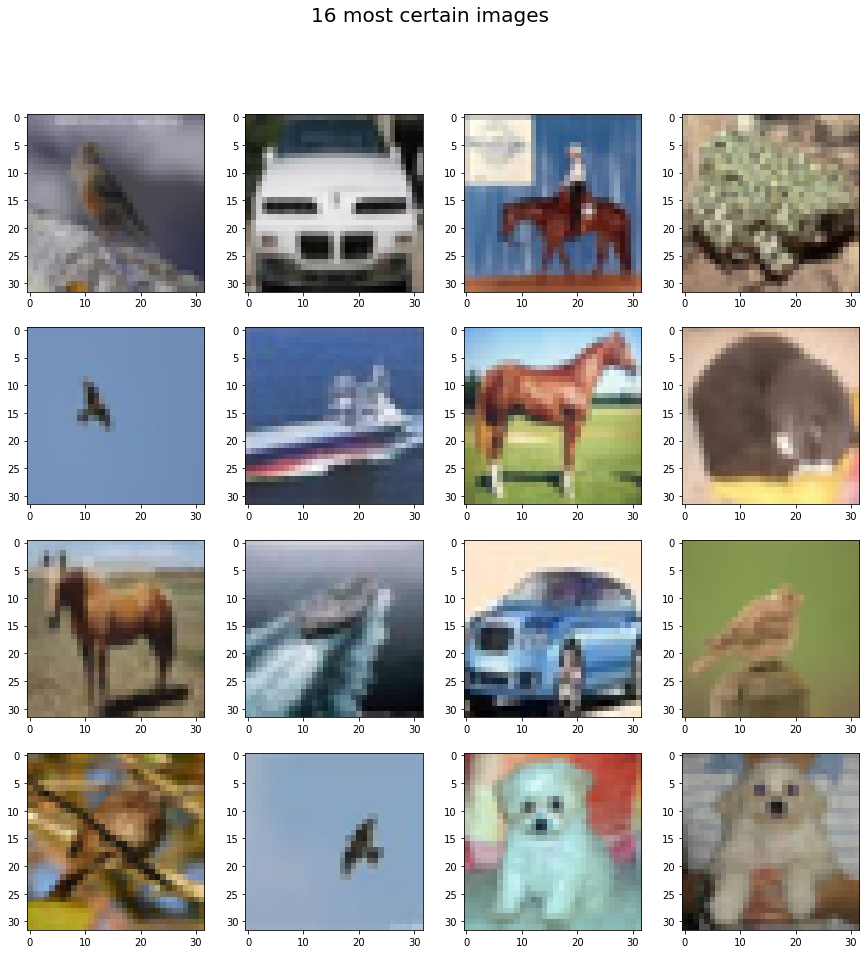

In [83]:
plot_grid(most_certain, title="16 most certain images")

### Now these results seem pretty solid!

If anyone wants to take a guess at what the objects in the first set of images are, be my guest :)

Just by creating a Bayesian mixed effects mixture model and performing inference using SVI, we were able to disentangle the sources of variation in the reaction times, and find the truly most baffling (and least baffling) images in the dataset.